# Inputs preparation and simulation

This notebook shw a complete example of simulation for the toy model of the building. It covers:

- obtaining the state-space representation from files describing the walls and the thermal circuits;
- estimate the time step and setling time from eigenvalue analysis of the state matrix;
- time integration by using Euler explicit and implicit methods.

In [1]:
import numpy as np
import pandas as pd
import pd_dm4bem

## Assembling and converting the thermal circuits to state-space
Consider the disassembled thermal circuits shown in Figure 1 that we want to assemble as shown in Figure 2 and then obtain the state-space representation.

![disassambled_TC](./bldg/ass_TCd.svg)
> Figure 1. Four disassembled thermal circuits: wall_out, TC0, TC1, TC2, TC3.

![disassambled_TC](./bldg/ass_TC.svg)
> Figure 2. The assembling of the four circuits from Figure 1.

The steps to obtain a state-space model from thermal circuits described in a folder are:
1. Obtain the disassambled set of thermal circuits from data given in a folder.
2. Assemble the set of thermal circuits.
3. Transform the thermal circuit into state-space representation.

In [2]:
# Obtain state-space representation
# =================================
# Disassembled thermal circuits
folder_path = "bldg"
TCd = pd_dm4bem.bldg2TCd(folder_path,
                         TC_auto_number=True)

# Assembled thermal circuit using assembly_lists.csv'
ass_lists = pd.read_csv(folder_path + '/assembly_lists.csv')
ass_matrix = pd_dm4bem.assemble_lists2matrix(ass_lists)
TC = pd_dm4bem.assemble_TCd_matrix(TCd, ass_matrix)

# State-space
[As, Bs, Cs, Ds, us] = pd_dm4bem.tc2ss(TC)

## Eigenvalues, time step and duration

The state-space representation allows us to do the eigenvalues analysis and to find:

- maximum time step: $\Delta t_{max} = 2 \mathrm{min} (-1 / \lambda)$, where $\lambda$ is the vector of eigenvalues of the state matrix As;
- minimum settling time: $t_{settle} = 4 \mathrm{max} (-1 / \lambda$). 

In [3]:
# Eigenvalue analysis
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
λ = np.sort(λ)

print('Time constants:')
print([f'{T:.2f} s' for T in -1 / λ])

dt_max = 2 * min(-1. / λ)
print(f'\nMaximum time step: {dt_max:.2f} s = {dt_max / 60:.2f} min')

t_settle = 4 * max(-1. / λ)
print(f'Minimum settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / 3600:.2f} h = \
{t_settle / (3600 * 24):.2f} days')

# time step
dt = np.floor(dt_max / 60) * 60   # s
print(f'Time step Δt = {dt} s = {dt / 60:.0f} min')

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
print(f'Duration: \
{duration:.0f} s = \
{duration / 60:.1f} min = \
{duration / 3600:.2f} h = \
{duration / (3600 * 24):.2f} days')

Time constants:
['249.30 s', '4093.21 s', '6729.13 s', '44033.06 s']

Maximum time step: 498.60 s = 8.31 min
Minimum settling time: 176132 s = 2935.5 min = 48.93 h = 2.04 days
Time step Δt = 480.0 s = 8 min
Duration: 176400 s = 2940.0 min = 49.00 h = 2.04 days


## Create input data set for step response

The [step response](https://en.m.wikipedia.org/wiki/Step_response) consists of the time response of the system when one or more inputs change instantaneously at time $t = 0$. The inputs of the system are the temperature ($T_o$, $T_{i,sp}$) and flow-rate sources ($\dot{Q}_a$, $\Phi_o$, $\Phi_i$, $\Phi_a$).

The input vector in time, $u$, is a DataFrame having as index the time (note that the year is __2000__ by convention) and as columns the values of the inputs arranged in the order given by the vector us (from the state-space representation). The transformation from inputs data set to the input vector is dne by the function `inputs_in_time()`.

In [4]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}S")

To = 10 * np.ones(n)
Ti_sp = 20 * np.ones(n)
Φa = 0 * np.ones(n)
Qa = Φo = Φi = Φa

data = {'To': To, 'Ti_sp': Ti_sp, 'Qa': Qa, 'Φo': Φo, 'Φi': Φi, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# Get input from input_data_set
u = pd_dm4bem.inputs_in_time(us, input_data_set)
u

,c1_q0,c2_q0,c3_q0,ow0_q0,c1_θ0,c2_θ0,ow0_θ0,ow0_θ4
2000-01-01 00:00:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:08:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:16:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:24:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-01 00:32:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2000-01-03 00:16:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-03 00:24:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-03 00:32:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0
2000-01-03 00:40:00,10.0,10.0,20.0,10.0,0.0,0.0,0.0,0.0


## Simulation

### Step response

#### Initial conditions

In [5]:
# Initial conditions
θ0 = 0                      # initial temperatures
θ_exp = pd.DataFrame(index=u.index)
θ_exp[As.columns] = θ0      # Fill θ with initial valeus θ0
θ_imp = θ_exp

#### Time integration

The formula for [Euler](https://en.m.wikipedia.org/wiki/Euler_method)  integration is:

$$ \theta_{k+1} = (I + \Delta t A_s) \theta _k + \Delta t B_s u_k $$

for forward (or explicit) and:

$$\theta_{k+1} = (I - \Delta t A_s)^{-1} ( \theta _k + \Delta t B_s u_k )$$

for backward (or implicit) integration.

In [6]:
I = np.eye(As.shape[0])     # identity matrix

for k in range(n - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

#### Output values

Once the state variables, i.e. the temperatures in nodes that have capacities $\theta_C$, are found, the temperatures in the other nodes are:

$$y = C_s \theta + D_s u$$.

In [7]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

#### Results plot

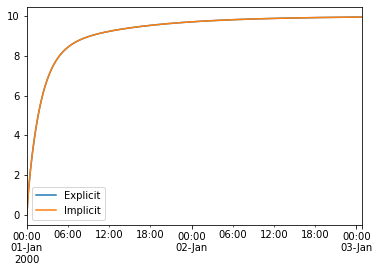

In [8]:
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)
y.plot();